In [50]:
#import package
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pylab as plt
import time
import keras

from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.merge import Concatenate
from keras.layers import LSTM, Input
from keras import optimizers
from keras import losses

%matplotlib inline

print('Done')

Done


In [74]:
def readData():
    data = pd.read_csv('C:/Users/yoon/Python/Stock_Prediction/data/Samsung_20_DIV.csv', parse_dates = [0])
    raw_dates = data.loc[:, 'date'].reset_index(drop=True)
    del data['date']
    raw_data = data.loc[:].reset_index(drop=True)
    return raw_data, raw_dates

def split_into_chunks(data, train, predict, step):
    train_set, label_set = [], []
        
    for i in range(0, len(data), step):
        try:  
            temp_train = data.loc[i:i+train-1, 'dSMA':'dCCI'].as_matrix()
            temp_label = data.loc[i+train-1+predict, 'return']
            if temp_label >= 0.0:
                temp_label = [1.0, 0.0]
            else:
                temp_label = [0.0, 1.0]
        except:
            break
        train_set.append(temp_train)
        label_set.append(temp_label)
    
    return train_set, label_set

def shuffle_in_unison(a1, a2, b):
    assert len(a1) == len(b)
    assert len(a2) == len(b)
    rng_state = np.random.get_state()
    np.random.shuffle(a1)
    np.random.set_state(rng_state)
    np.random.shuffle(a2)
    np.random.shuffle(b)
    return a1, a2, b

def create_Xt_Yt(X, y, percentage=0.8):
    X_train1 = X[0:int(len(X) * percentage)]
    X_train2 = X[0:int(len(X) * percentage)]
    Y_train = y[0:int(len(y) * percentage)]
    #X_train1,X_train2, Y_train = shuffle_in_unison(X_train1, X_train2, Y_train)
    X_test1 = X[int(len(X) * percentage):]
    X_test2 = X[int(len(X) * percentage):]
    Y_test = y[int(len(X) * percentage):]
    #X_test1, X_test2, Y_test = shuffle_in_unison(X_test1, X_test2, Y_test)
    
    return X_train1, X_train2, X_test1, X_test2, Y_train, Y_test

print('Done')

Done


In [68]:
timeSeriesList, dates = readData()
TIME_STEPS = 10
TARGET_TIME = 1
STEP_SIZE = 1
DATA_DIM=10

print('Done')

Done


In [75]:
X, Y = split_into_chunks(timeSeriesList, TIME_STEPS, TARGET_TIME, STEP_SIZE)
X, Y = np.array(X), np.array(Y)
#X = X.reshape(-1, DATA_SIZE_ON_TRAIN * 10)
X_train1, X_train2, X_test1, X_test2, Y_train, Y_test = create_Xt_Yt(X, Y)
print('Done')

Done


In [69]:
encoder_A = Sequential()
encoder_A.add(LSTM(16, return_sequences=False, input_shape=(TIME_STEPS, DATA_DIM)))

encoder_B = Sequential()
encoder_B.add(LSTM(16, return_sequences=False, input_shape=(TIME_STEPS, DATA_DIM)))

decoder = Sequential()
decoder.add(Merge([encoder_A, encoder_B], mode = 'concat'))
decoder.add(Dense(2, activation = 'softmax'))

decoder.compile(optimizer='adam', loss='binary_crossentropy',
               metrics=['accuracy'])
print("done")

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:8: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


done


In [76]:
print("Training...")
decoder.fit([X_train1, X_train2], Y_train,
            batch_size=128, epochs=5)

print("Evaluating...")
score = decoder.evaluate([X_test1, X_test2], Y_test, batch_size=128)
print("\nTest loss and accuracy:" + str(score))

Training...
Epoch 1/5
4166/4166 [==============================] - 2s - loss: nan - acc: 0.0000e+00     
Epoch 2/5
4166/4166 [==============================] - 2s - loss: nan - acc: 0.0000e+00     
Epoch 3/5
4166/4166 [==============================] - 2s - loss: nan - acc: 0.0000e+00     
Epoch 4/5
4166/4166 [==============================] - 2s - loss: nan - acc: 0.0000e+00     
Epoch 5/5
4166/4166 [==============================] - 2s - loss: nan - acc: 0.0000e+00     
Evaluating...
 896/1042 [========================>.....] - ETA: 0s
Test loss and accuracy:[nan, 0.0]


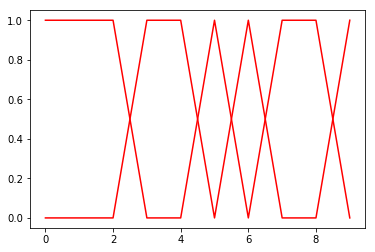

In [77]:
predicted = decoder.predict([X_test1, X_test2])
plt.figure(figsize=(20, 6))
plt.xticks(np.arange(0,101,5))
plt.yticks(np.arange(0,1.1,0.1))
plt.grid(True)
plt.plot(range(0,100), predicted[:100], color='blue')
plt.scatter(range(0,100),predicted[:100].round(), color='red', marker='x')
plt.scatter(range(0,100), Y_test[:100], color='black', marker='.')